# Longitudinal QuasiCopula GWAS

Here we adopt the variance component model framework

$$\mathbf{\Gamma}_i(\mathbf{\theta}) = \sum_{k=1}^m \theta_k\mathbf{V}_{ik}, \quad \theta_k \ge 0$$

In [1]:
using Revise
using DataFrames, Random, GLM, QuasiCopula
using ForwardDiff, Test, LinearAlgebra
using LinearAlgebra: BlasReal, copytri!
using ToeplitzMatrices
using BenchmarkTools
using SnpArrays
using MendelPlots

# using MendelPlots
ENV["COLUMNS"] = 240

BLAS.set_num_threads(1)
Threads.nthreads()

# simulate PLINK data where each SNP has at least min_ma copies of the alt allele
function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
        p::Int64, mafs::Vector{Float64}; min_ma::Int = 1)
    all(0.0 .<= mafs .<= 0.5) || throw(ArgumentError("vector of minor allele frequencies must be in (0, 0.5)"))
#     any(mafs .<= 0.0005) && @warn("Provided minor allele frequencies contain entries smaller than 0.0005, simulation may take long if sample size is small and min_ma = $min_ma is large")

    #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
    A1 = BitArray(undef, n, p) 
    A2 = BitArray(undef, n, p) 
    for j in 1:p
        minor_alleles = 0
        maf = mafs[j]
        while minor_alleles <= min_ma
            for i in 1:n
                A1[i, j] = rand(Bernoulli(maf))
                A2[i, j] = rand(Bernoulli(maf))
            end
            minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
        end
    end

    #fill the SnpArray with the corresponding x_tmp entry
    return _make_snparray(s, A1, A2)
end


# function simulate_random_snparray(s::Union{String, UndefInitializer}, n::Int64,
#     p::Int64; mafs::Vector{Float64}=zeros(Float64, p), min_ma::Int = 5)

#     #first simulate a random {0, 1, 2} matrix with each SNP drawn from Binomial(2, r[i])
#     A1 = BitArray(undef, n, p) 
#     A2 = BitArray(undef, n, p) 
#     for j in 1:p
#         minor_alleles = 0
#         maf = 0
#         while minor_alleles <= min_ma
#             maf = 0.5rand()
#             for i in 1:n
#                 A1[i, j] = rand(Bernoulli(maf))
#                 A2[i, j] = rand(Bernoulli(maf))
#             end
#             minor_alleles = sum(view(A1, :, j)) + sum(view(A2, :, j))
#         end
#         mafs[j] = maf
#     end

#     #fill the SnpArray with the corresponding x_tmp entry
#     return _make_snparray(s, A1, A2)
# end

function _make_snparray(s::Union{String, UndefInitializer}, A1::BitArray, A2::BitArray)
    n, p = size(A1)
    x = SnpArray(s, n, p)
    for i in 1:(n*p)
        c = A1[i] + A2[i]
        if c == 0
            x[i] = 0x00
        elseif c == 1
            x[i] = 0x02
        elseif c == 2
            x[i] = 0x03
        else
            throw(MissingException("matrix shouldn't have missing values!"))
        end
    end
    return x
end

┌ Info: Precompiling QuasiCopula [c47b6ae2-b804-4668-9957-eb588c99ffbc]
└ @ Base loading.jl:1342


_make_snparray (generic function with 1 method)

## Simulate data

In [61]:
function simulate_VC_longitudinal(;
    n = 1000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of nongenetic covariates, including intercept
    m = 1, # number of variance components
    q = 1000, # number of SNPs
    k = 10, # number of causal SNPs
    maf = 0.5rand(),
    causal_snp_β = 0.5rand(),
    seed = 2022,
    y_distribution = Bernoulli,
    T = Float64,
    )
    Random.seed!(seed)
    m == 1 || m == 2 || error("m (number of VC) must be 1 or 2")
    
    # non-genetic effect sizes
    Random.seed!(seed)
#     βtrue = [1.0; rand(-0.05:0.1:0.05, p-1)]
#     βtrue = [1.0; rand(-0.5:1:0.5, p-1)]
    βtrue = [1.0; rand(-5:10:5, p-1) .* rand(Uniform(0, 5), p-1)]
    dist = y_distribution()
    link = canonicallink(dist)
    Dist = typeof(dist)
    Link = typeof(link)

    # variance components
    θtrue = fill(0.1, m)

    # simulate (nongenetic) design matrices
    Random.seed!(seed)
    X_full = Matrix{Float64}[]
    for i in 1:n
        nobs = rand(d_min:d_max) # number of obs for this sample
        push!(X_full, hcat(ones(nobs), randn(nobs, p - 1)))
    end
    
    # simulate causal alleles
    Random.seed!(seed)
    γtrue = zeros(q)
#     γtrue[1:k] .= rand([-0.2, 0.2], k)
    γtrue[1:k] .= causal_snp_β
    shuffle!(γtrue)
    
    # set minor allele freq
    mafs = fill(maf, q)
    
    # simulate random SnpArray with q SNPs with prespecified maf
    Random.seed!(seed)
    G = simulate_random_snparray(undef, n, q, mafs)
    Gfloat = convert(Matrix{T}, G, center=true, scale=false)
    
    # effect of causal alleles
    η_G = Gfloat * γtrue

    # simulate phenotypes
    if y_distribution == Normal
        τtrue = 10.0
        σ2 = inv(τtrue)
        σ = sqrt(σ2)
        obs = Vector{GaussianCopulaVCObs{T}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            vecd = Vector{ContinuousUnivariateDistribution}(undef, size(X, 1))
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i], σ)
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GaussianCopulaVCObs(y, X, V)
        end
        qc_model = GaussianCopulaVCModel(obs)
    else
        obs = Vector{GLMCopulaVCObs{T, Dist, Link}}(undef, n)
        for i in 1:n
            # data matrix
            X = X_full[i]
            η = X * βtrue
            η .+= η_G[i] # add genetic effects
            μ = GLM.linkinv.(link, η)
            # VC matrices
            V1 = ones(size(X, 1), size(X, 1))
            V2 = Matrix(I, size(X, 1), size(X, 1))
            Γ = m == 1 ? θtrue[1] * V1 : θtrue[1] * V1 + θtrue[2] * V2
            vecd = Vector{DiscreteUnivariateDistribution}(undef, size(X, 1))
            for i in 1:size(X, 1)
                vecd[i] = y_distribution(μ[i])
            end
            nonmixed_multivariate_dist = NonMixedMultivariateDistribution(vecd, Γ)
            # simuate single vector y
            y = Vector{T}(undef, size(X, 1))
            res = Vector{T}(undef, size(X, 1))
            rand(nonmixed_multivariate_dist, y, res)
            V = m == 1 ? [V1] : [V1, V2]
            obs[i] = GLMCopulaVCObs(y, X, V, dist, link)
        end
        qc_model = GLMCopulaVCModel(obs)
    end
    return qc_model, G, βtrue, θtrue, γtrue
end

k = 0 # number of causal SNPs
maf = 0.3

qc_model, G, βtrue, θtrue, γtrue = simulate_VC_longitudinal(
    n = 5000, # sample size
    d_min = 1, # min number of observations per sample
    d_max = 5, # max number of observations per sample
    p = 3, # number of fixed effects, including intercept
    m = 2, # number of variance components
    q = 1000, # number of SNPs
    k = k, # number of causal SNPs
    seed = 123,
    y_distribution = Normal,
    T = Float64,
    maf = maf,
    causal_snp_β = 0.2
)

@show qc_model;

qc_model = Quasi-Copula Variance Component Model
  * base distribution: Normal
  * link function: IdentityLink
  * number of clusters: 5000
  * cluster size min, max: 1, 5
  * number of variance components: 2
  * number of fixed effects: 3



## Fit Null model

In [62]:
@time optm = QuasiCopula.fit!(qc_model,
    Ipopt.IpoptSolver(
        print_level = 5, 
        tol = 10^-6, 
        max_iter = 500,
        accept_after_max_steps = 10,
        warm_start_init_point="yes", 
        limited_memory_max_history = 6, # default value
        hessian_approximation = "limited-memory",
#         derivative_test="first-order"
    )
);

This is Ipopt version 3.13.4, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:        0
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:        6
                     variables with only lower bounds:        3
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0  

┌ Warning: Optimization unsuccesful; got UserLimit
└ @ QuasiCopula /Users/biona001/.julia/dev/QuasiCopula/src/parameter_estimation/fit_gaussian_vc.jl:36


In [63]:
@show βtrue
@show qc_model.β
@show qc_model.∇β

@show θtrue
@show qc_model.θ
@show qc_model.∇θ;

βtrue = [1.0, 3.418127752912886, -0.13673900377582093]
qc_model.β = [0.9968009899828827, 3.417849196334565, -0.13258420195041917]
qc_model.∇β = [9.265292355564725e-7, 1.7151550957272832e-6, -8.227565482243904e-7]
θtrue = [0.1, 0.1]
qc_model.θ = [0.10150376267419975, 0.0813990830263587]
qc_model.∇θ = [-7.887353459246071e-8, 4.745787685056513e-8]


## Score tests

In [78]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

 41.040935 seconds (554.71 M allocations: 51.014 GiB, 13.10% gc time, 0.24% compilation time)


1000-element Vector{Float64}:
 0.8237297828472543
 0.7914778608754015
 0.8580537622818565
 0.1790840451750697
 0.6336381034682012
 0.5735103504380604
 0.6397032579737263
 0.9144745331499616
 0.37089412071912226
 0.8691032285248206
 0.4265016521116512
 0.8417803158895215
 0.5830621607750082
 ⋮
 0.5190498196244712
 0.07564486790887683
 0.5565333768095962
 0.6903895086011657
 0.9955222732970194
 0.8291027940642748
 0.6492323246969839
 0.9820688682837044
 0.8038414447407634
 0.6251117016870258
 0.8892979334454276
 0.5603446531205865

In [90]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

R = 15.516368841638483
Q = 4850.638828062906
W = [-27.529081985380476, 6.971420966299501, 45.5872379805906, 28.23957058926966, 2.785387601783027]
R = 18.250440708910748
Q = 4764.6374164206645
W = [-47.81131672681561, -14.932314807265096, -2.473884228777594, 28.186147906123683, 16.613599575049374]
R = 12.447630243720125
Q = 4842.5940561437965
W = [27.969113131904233, 0.7843163061729884, 40.25995383903372, 26.086364291829657, 28.557985559906385]


LoadError: UndefVarError: fdsa not defined

In [91]:
# autodiff
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

R = 48.93676316775848
Q = 48249.10148308352
W = [-53.75471201607795, -757.0017525975716, 815.940580547202, 89.06421289611308, 8.784777855569063, -5.812874067048425]
R = 57.559697361826615
Q = 47393.649039580705
W = [-70.1708955278449, -288.0319313493205, -202.93399616662492, 88.89572417174894, 52.397297078066124, -6.673328893331838]
R = 39.25833031257401
Q = 48169.08047337908
W = [95.82626334725619, -699.6740924648444, 551.604288597529, 82.27325892327589, 90.06845545867083, -3.132864848732869]


LoadError: UndefVarError: fdsa not defined

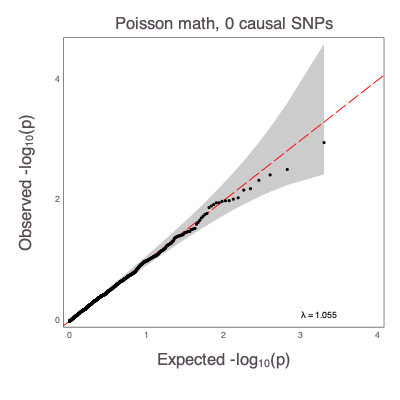

In [10]:
qq(pvals, dpi=80, titles="Poisson math, $k causal SNPs")
display("image/png", read("qqplot.png"))

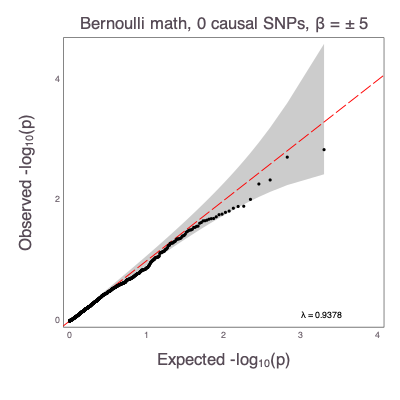

In [60]:
qq(pvals, dpi=80, titles="Bernoulli math, $k causal SNPs, β = ± 5")
display("image/png", read("qqplot.png"))

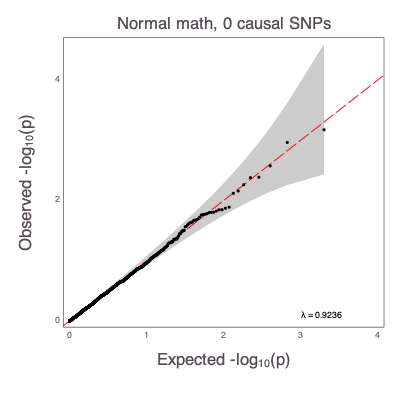

In [79]:
qq(pvals, dpi=80, titles="Normal math, $k causal SNPs")
display("image/png", read("qqplot.png"))

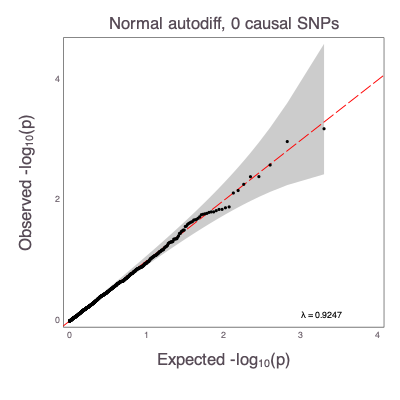

In [76]:
qq(pvals, dpi=80, titles="Normal autodiff, $k causal SNPs")
display("image/png", read("qqplot.png"))

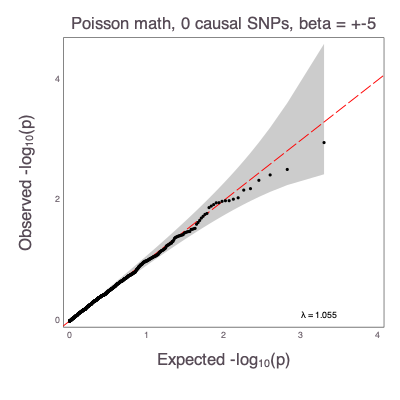

In [22]:
qq(pvals, dpi=80, titles="Poisson math, $k causal SNPs, beta = +-5")
display("image/png", read("qqplot.png"))

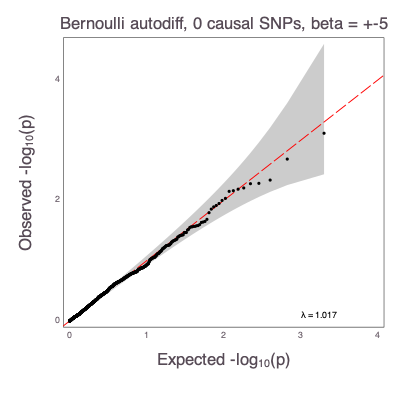

In [24]:
qq(pvals, dpi=80, titles="Bernoulli autodiff, $k causal SNPs, beta = +-5")
display("image/png", read("qqplot.png"))

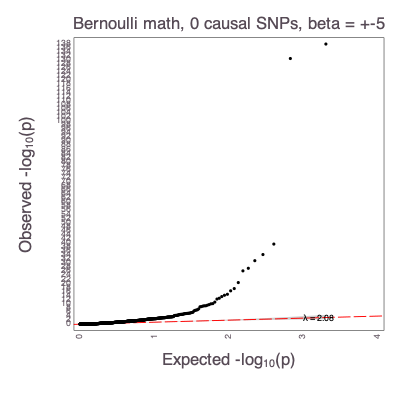

In [26]:
qq(pvals, dpi=80, titles="Bernoulli math, $k causal SNPs, beta = +-5")
display("image/png", read("qqplot.png"))

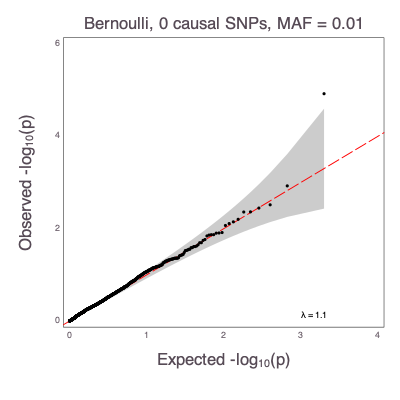

In [33]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, MAF = $maf")
display("image/png", read("qqplot.png"))

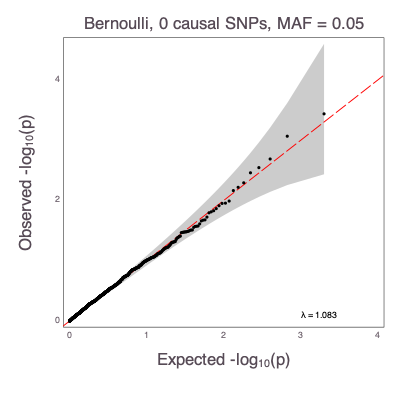

In [28]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, MAF = $maf")
display("image/png", read("qqplot.png"))

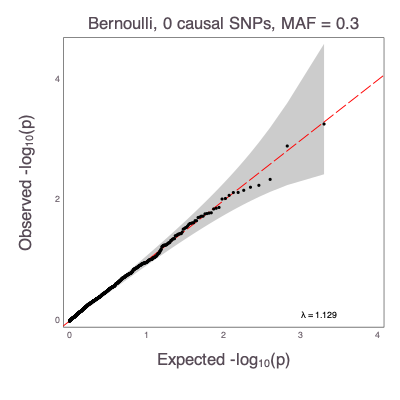

In [23]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, MAF = $maf")
display("image/png", read("qqplot.png"))

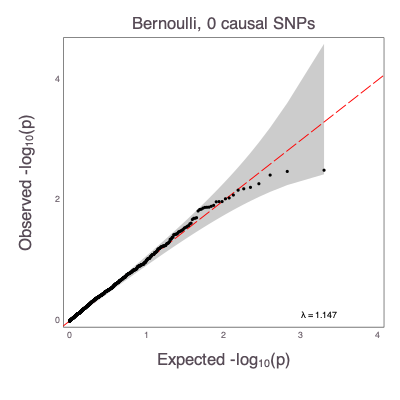

In [8]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs, MAF = $maf")
display("image/png", read("qqplot.png"))

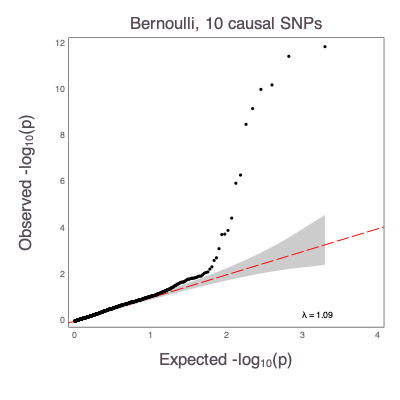

In [155]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

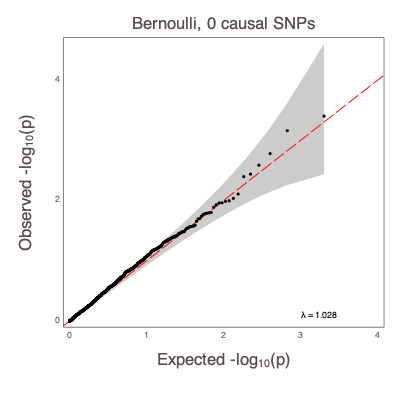

In [149]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

In [156]:
count(x -> x < 0.05 / 1000, pvals)

9

## QQ plots

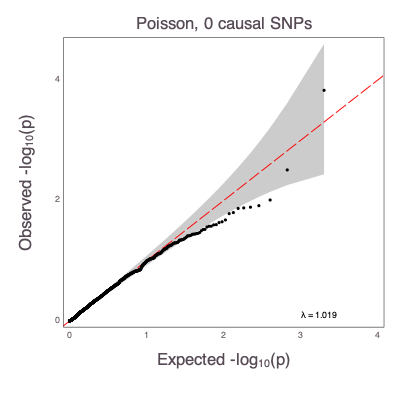

In [55]:
qq(pvals, dpi=80, titles="Poisson, $k causal SNPs")
display("image/png", read("qqplot.png"))

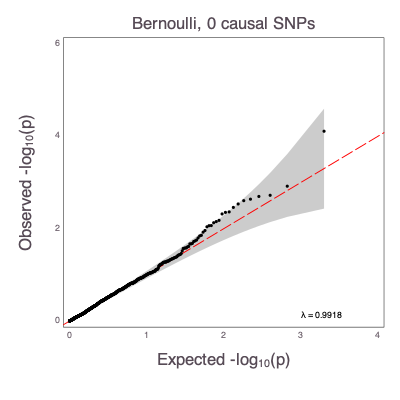

In [48]:
qq(pvals, dpi=80, titles="Bernoulli, $k causal SNPs")
display("image/png", read("qqplot.png"))

## Compare to autodiff

In [140]:
# autodiff
@time pvals = QuasiCopula.GWASCopulaVCModel_autodiff(qc_model, G)

P = [1540.0795495375382 388.81661636692667 -390.919604383407 -1071.9134557805355 -889.7206227627037; 388.81661636692667 1680.900898174432 108.0567749729837 412.642850171299 450.4978714573309; -390.9196043834071 108.05677497298362 1673.5029966306736 -458.0865000172919 -449.1314109025623; -1071.9134557805355 412.64285017129913 -458.08650001729177 5538.665487454165 365.9470281247379; -889.7206227627036 450.4978714573308 -449.1314109025623 365.9470281247377 1856.17550859894]


LoadError: UndefVarError: fff not defined

In [142]:
# mathematical
@time pvals = QuasiCopula.GWASCopulaVCModel(qc_model, G)

gc.w2 = [0.1736586533404102]
res = [0.5368079955758741]
η = [1.2442295970952018]
μ = [0.7762993786811505]
varμ = [0.1736586533404102]


LoadError: UndefVarError: dist not defined

In [117]:
P_math = [235.87107080407694 -295.75288430834314 363.51381725869425 -87.16409342631925 -69.19262886679792; -295.7528843083432 -113.90435391044791 498.13224289048986 339.1504112656208 342.6501355324116; 363.51381725869436 498.1322428904897 -364.5189479649758 -406.5718425301778 -401.25332234815977; -87.16409342631925 339.1504112656208 -406.5718425301778 12170.338509131507 10015.885120312969; -69.19262886679792 342.6501355324116 -401.25332234815977 10015.885120312969 10518.729825607808]
P_auto = [764.6129374133852 93.48926956904221 -129.79946727913 -87.16409342631869 -69.19262886679778; 93.48926956904208 561.1492746822455 322.5998986050421 339.1504112656198 342.65013553241147; -129.79946727912994 322.599898605042 356.06593209779396 -406.57184253017635 -401.2533223481599; -87.16409342631871 339.1504112656198 -406.57184253017635 12170.3385091317 10015.88512031298; -69.19262886679778 342.6501355324114 -401.2533223481599 10015.88512031298 10518.72982560792]

[vec(P_math) vec(P_auto)]

25×2 Matrix{Float64}:
   235.871     764.613
  -295.753      93.4893
   363.514    -129.799
   -87.1641    -87.1641
   -69.1926    -69.1926
  -295.753      93.4893
  -113.904     561.149
   498.132     322.6
   339.15      339.15
   342.65      342.65
   363.514    -129.799
   498.132     322.6
  -364.519     356.066
  -406.572    -406.572
  -401.253    -401.253
   -87.1641    -87.1641
   339.15      339.15
  -406.572    -406.572
 12170.3     12170.3
 10015.9     10015.9
   -69.1926    -69.1926
   342.65      342.65
  -401.253    -401.253
 10015.9     10015.9
 10518.7     10518.7